<a href="https://colab.research.google.com/github/glwtr22/paper_review_code/blob/main/Deeplabv3plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#코드는 Yude Wang님 깃허브에서 가져왔습니다.

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


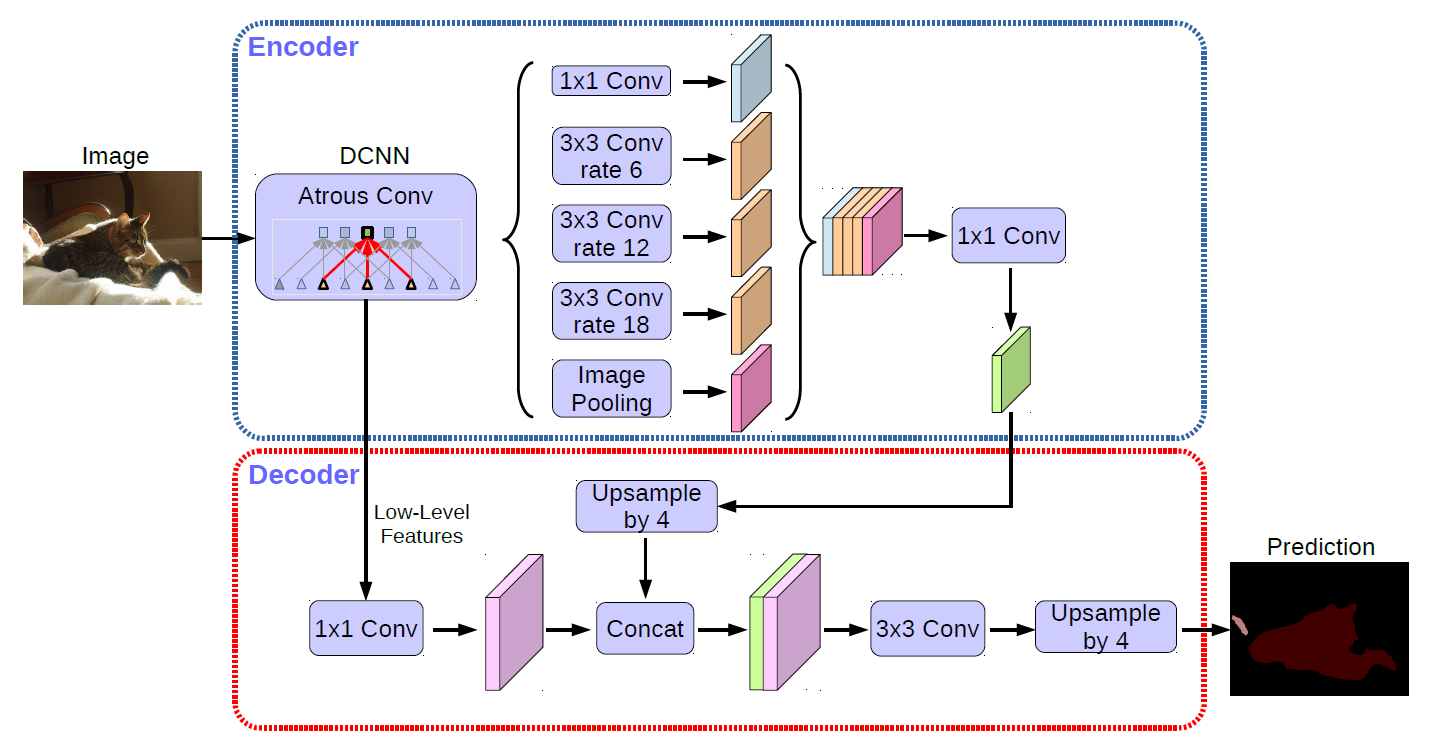

In [2]:
from IPython.display import Image
Image('/gdrive/My Drive/DLV3plus.png')

In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from net.sync_batchnorm import SynchronizedBatchNorm2d
from torch.nn import init
from torchvision import models
import net.resnet_atrous as atrousnet
import net.xception as xception
from net.backbone import build_backbone
from net.ASPP import ASPP

In [ ]:
def build_backbone(backbone_name, pretrained=True, os=16):
	if backbone_name == 'res50_atrous':
		net = atrousnet.resnet50_atrous(pretrained=pretrained, os=os)
		return net
	elif backbone_name == 'res101_atrous':
		net = atrousnet.resnet101_atrous(pretrained=pretrained, os=os)
		return net
	elif backbone_name == 'res152_atrous':
		net = atrousnet.resnet152_atrous(pretrained=pretrained, os=os)
		return net
	elif backbone_name == 'xception' or backbone_name == 'Xception':
		net = xception.xception(pretrained=pretrained, os=os)
		return net
	else:
		raise ValueError('backbone.py: The backbone named %s is not supported yet.'%backbone_name)

In [ ]:
class deeplabv3plus(nn.Module):
	def __init__(self, cfg):
		super(deeplabv3plus, self).__init__()
		self.backbone = None		
		self.backbone_layers = None
		input_channel = 2048		
		self.aspp = ASPP(dim_in=input_channel, 
				dim_out=cfg.MODEL_ASPP_OUTDIM, 
				rate=16//cfg.MODEL_OUTPUT_STRIDE,
				bn_mom = cfg.TRAIN_BN_MOM)
		self.dropout1 = nn.Dropout(0.5)
		self.upsample4 = nn.UpsamplingBilinear2d(scale_factor=4)
		self.upsample_sub = nn.UpsamplingBilinear2d(scale_factor=cfg.MODEL_OUTPUT_STRIDE//4)

		indim = 256
		self.shortcut_conv = nn.Sequential(
				nn.Conv2d(indim, cfg.MODEL_SHORTCUT_DIM, cfg.MODEL_SHORTCUT_KERNEL, 1, padding=cfg.MODEL_SHORTCUT_KERNEL//2,bias=True),
				SynchronizedBatchNorm2d(cfg.MODEL_SHORTCUT_DIM, momentum=cfg.TRAIN_BN_MOM),
				nn.ReLU(inplace=True),		
		)		
		self.cat_conv = nn.Sequential(
				nn.Conv2d(cfg.MODEL_ASPP_OUTDIM+cfg.MODEL_SHORTCUT_DIM, cfg.MODEL_ASPP_OUTDIM, 3, 1, padding=1,bias=True),
				SynchronizedBatchNorm2d(cfg.MODEL_ASPP_OUTDIM, momentum=cfg.TRAIN_BN_MOM),
				nn.ReLU(inplace=True),
				nn.Dropout(0.5),
				nn.Conv2d(cfg.MODEL_ASPP_OUTDIM, cfg.MODEL_ASPP_OUTDIM, 3, 1, padding=1,bias=True),
				SynchronizedBatchNorm2d(cfg.MODEL_ASPP_OUTDIM, momentum=cfg.TRAIN_BN_MOM),
				nn.ReLU(inplace=True),
				nn.Dropout(0.1),
		)
		self.cls_conv = nn.Conv2d(cfg.MODEL_ASPP_OUTDIM, cfg.MODEL_NUM_CLASSES, 1, 1, padding=0)
		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
			elif isinstance(m, SynchronizedBatchNorm2d):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)
		self.backbone = build_backbone(cfg.MODEL_BACKBONE, os=cfg.MODEL_OUTPUT_STRIDE)
		self.backbone_layers = self.backbone.get_layers()

	def forward(self, x):
		x_bottom = self.backbone(x)
		layers = self.backbone.get_layers()
		feature_aspp = self.aspp(layers[-1])
		feature_aspp = self.dropout1(feature_aspp)
		feature_aspp = self.upsample_sub(feature_aspp)

		feature_shallow = self.shortcut_conv(layers[0])
		feature_cat = torch.cat([feature_aspp,feature_shallow],1)
		result = self.cat_conv(feature_cat) 
		result = self.cls_conv(result)
		result = self.upsample4(result)
		return result